## Import Modules

In [7]:
#pip install Keras-Preprocessing


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [12]:
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from tqdm.notebook import tqdm
warnings.filterwarnings('ignore')
%matplotlib inline

import pandas as pd
import tensorflow as tf
from keras_preprocessing.image import load_img
from keras.models import Sequential,Model
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D, Input


## Load the data

In [8]:
!unzip -q '/content/drive/MyDrive/utkface-new.zip'

In [9]:
Base = '/content/utkface_aligned_cropped/UTKFace'

In [11]:
## age, gender, ethnicity, labels of image
image_paths , age_labels, gender_labels = list(),list(),list()

for filenames in tqdm(os.listdir(Base)):
  image_path = os.path.join(Base, filenames)
  temp = filenames.split('_')
  age = int(temp[0])
  gender = int(temp[1])
  image_paths.append(image_path)
  age_labels.append(age)
  gender_labels.append(gender)

  0%|          | 0/23708 [00:00<?, ?it/s]

## Convert tod ata frame

In [55]:
df = pd.DataFrame()
df['image'] , df['age'], df['gender'] = image_paths,age_labels, gender_labels
df.head()

,image,age,gender
0,/content/utkface_aligned_cropped/UTKFace/8_1_3...,8,1
1,/content/utkface_aligned_cropped/UTKFace/26_1_...,26,1
2,/content/utkface_aligned_cropped/UTKFace/2_1_2...,2,1
3,/content/utkface_aligned_cropped/UTKFace/26_0_...,26,0
4,/content/utkface_aligned_cropped/UTKFace/11_1_...,11,1


In [23]:
## map labels for labels
gender_dict = {0:'Male', 1:'Female'}

## Exploratory Data Analysis|

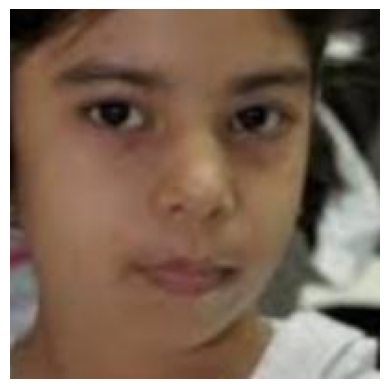

In [24]:
from PIL import Image
img = Image.open(df['image'][0])
plt.axis('off')
plt.imshow(img);

<Axes: xlabel='age', ylabel='Density'>

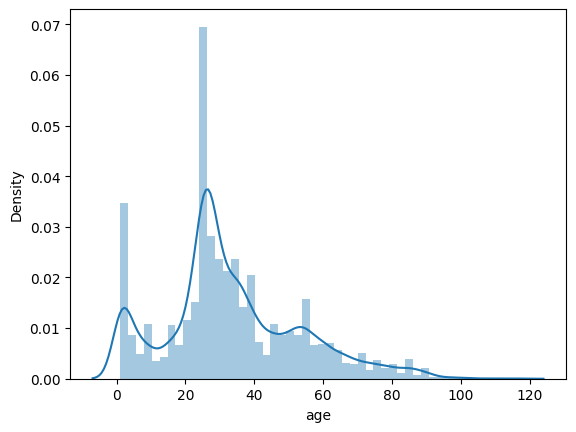

In [25]:
sns.distplot(df['age'])

In [37]:
df['gender'].value_counts()


0    12391
1    11317
Name: gender, dtype: int64

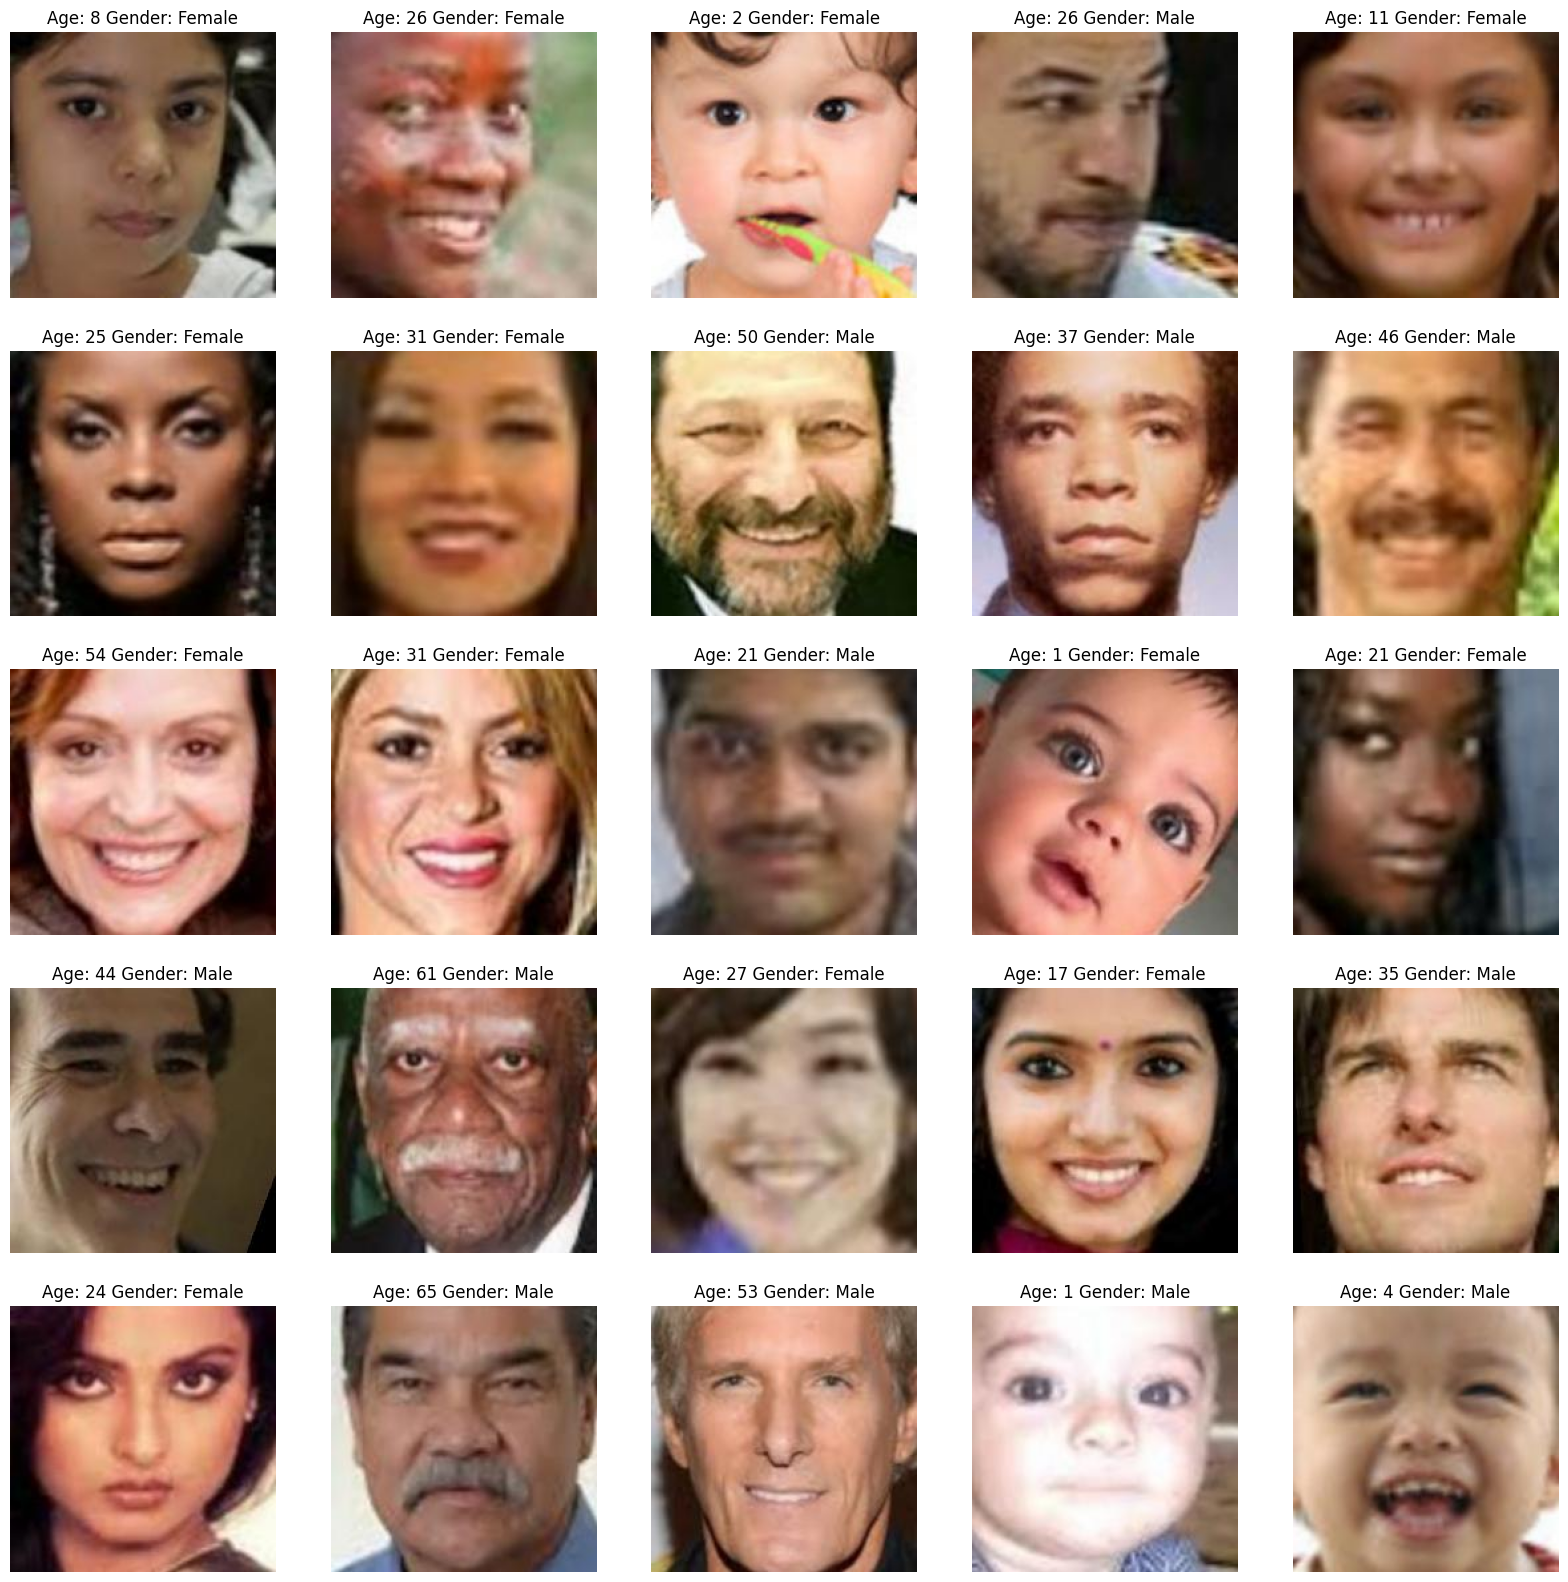

In [58]:
plt.figure(figsize = (20,20))
files = df.iloc[0:25]
for index, file, age, gender in files.itertuples():
  plt.subplot(5,5, index+1)
  image =load_img(file)
  img = np.array(image)
  plt.imshow(img)
  plt.title('Age: {} Gender: {}'.format(age, gender_dict[gender]))
  plt.axis('off')

## Feature Extraction

In [59]:
def extract_features(images):
  feature = []
  for image in tqdm(images):
    img = load_img(image, grayscale = True)
    img = img.resize((128,128), Image.ANTIALIAS)
    img = np.array(img)
    feature.append(img)
  feature = np.array(feature)
  feature = feature.reshape(len(feature), 128, 128,1)
  return feature

In [60]:
X = extract_features(df['image'])

  0%|          | 0/23708 [00:00<?, ?it/s]

In [61]:
X.shape

(23708, 128, 128, 1)

## Normalize the images

In [62]:
X = X/255.0

In [64]:
df

,image,age,gender
0,/content/utkface_aligned_cropped/UTKFace/8_1_3...,8,1
1,/content/utkface_aligned_cropped/UTKFace/26_1_...,26,1
2,/content/utkface_aligned_cropped/UTKFace/2_1_2...,2,1
3,/content/utkface_aligned_cropped/UTKFace/26_0_...,26,0
4,/content/utkface_aligned_cropped/UTKFace/11_1_...,11,1
...,...,...,...
23703,/content/utkface_aligned_cropped/UTKFace/28_1_...,28,1
23704,/content/utkface_aligned_cropped/UTKFace/27_0_...,27,0
23705,/content/utkface_aligned_cropped/UTKFace/14_0_...,14,0
23706,/content/utkface_aligned_cropped/UTKFace/65_0_...,65,0


In [66]:
y_gender = np.array(df['gender'])
y_age = np.array(df['age'])

In [67]:
input_shape = (128,128,1)

## Model Creation

In [70]:
inputs = Input((input_shape))
## convolutional layers
conv1 = Conv2D(32,kernel_size = (3,3), activation = 'relu')(inputs)
max_p1 = MaxPooling2D(pool_size = (2,2))(conv1)
conv2 = Conv2D(62,kernel_size = (3,3), activation = 'relu')(max_p1)
max_p2 = MaxPooling2D(pool_size = (2,2))(conv2)
conv3 = Conv2D(128,kernel_size = (3,3), activation = 'relu')(max_p2)
max_p3 = MaxPooling2D(pool_size = (2,2))(conv3)
conv4 = Conv2D(256,kernel_size = (3,3), activation = 'relu')(max_p3)
max_p4 = MaxPooling2D(pool_size = (2,2))(conv4)


flatten = Flatten()(max_p4)
## fully conected layers
fc1 = Dense(256, activation = 'relu')(flatten)
fc2 = Dense(256, activation = 'relu')(flatten)
## drop out layers
dropout1 = Dropout(0.3)(fc1)
dropout2 = Dropout(0.3)(fc2)

output_1 = Dense(1, activation = 'sigmoid', name = 'gender_out')(dropout1)
output_2 = Dense(1, activation = 'relu', name = 'age_out')(dropout2)

# compiling
model = Model(inputs = [inputs], outputs = [output_1, output_2])
model.compile(loss = ['binary_crossentropy', 'mae'], optimizer = 'adam', metrics = ['accuracy'])


In [71]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_5 (Conv2D)              (None, 126, 126, 32  320         ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 max_pooling2d_5 (MaxPooling2D)  (None, 63, 63, 32)  0           ['conv2d_5[0][0]']               
                                                                                            

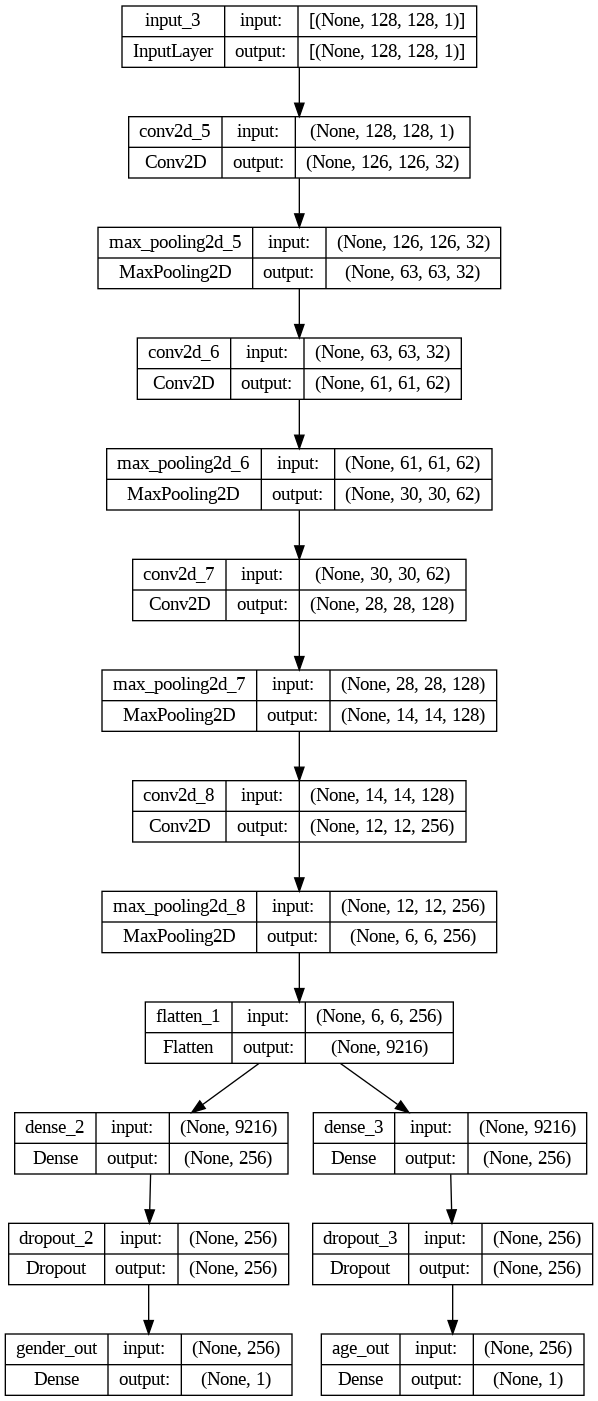

In [75]:
from tensorflow.keras.utils import plot_model
plot_model(model,show_shapes = True)

In [76]:
# train the model
history = model.fit(x = X, y = [y_gender, y_age], batch_size = 32, epochs = 30, validation_split = 0.2)

Epoch 1/30
593/593 [==============================] - 1063s 2s/step - loss: 15.8378 - gender_out_loss: 0.6868 - age_out_loss: 15.1510 - gender_out_accuracy: 0.5520 - age_out_accuracy: 0.0467 - val_loss: 12.6749 - val_gender_out_loss: 0.5477 - val_age_out_loss: 12.1273 - val_gender_out_accuracy: 0.7307 - val_age_out_accuracy: 0.0491
Epoch 2/30
593/593 [==============================] - 887s 1s/step - loss: 11.9465 - gender_out_loss: 0.5027 - age_out_loss: 11.4438 - gender_out_accuracy: 0.7571 - age_out_accuracy: 0.0379 - val_loss: 10.7382 - val_gender_out_loss: 0.4335 - val_age_out_loss: 10.3047 - val_gender_out_accuracy: 0.7957 - val_age_out_accuracy: 0.0289
Epoch 3/30
593/593 [==============================] - 864s 1s/step - loss: 10.2481 - gender_out_loss: 0.4198 - age_out_loss: 9.8283 - gender_out_accuracy: 0.8076 - age_out_accuracy: 0.0251 - val_loss: 10.1139 - val_gender_out_loss: 0.3781 - val_age_out_loss: 9.7358 - val_gender_out_accuracy: 0.8252 - val_age_out_accuracy: 0.0084
Ep

## Plot the results

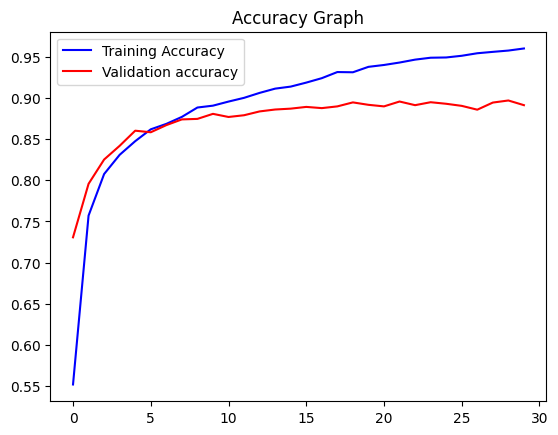

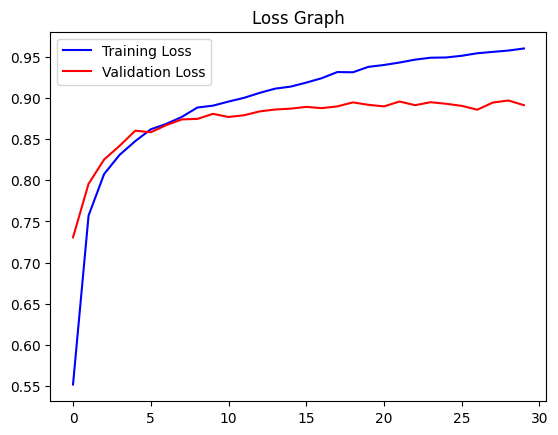

<Figure size 640x480 with 0 Axes>

In [77]:
# for gender
acc = history.history['gender_out_accuracy']
val_acc = history.history['val_gender_out_accuracy']
epochs = range(len(acc))


plt.plot(epochs, acc,'b', label = 'Training Accuracy')
plt.plot(epochs,val_acc,'r', label ='Validation accuracy')
plt.title('Accuracy Graph')
plt.legend()
plt.figure()



loss = history.history['gender_out_loss']
val_loss = history.history['val_gender_out_loss']


plt.plot(epochs, acc,'b', label = 'Training Loss')
plt.plot(epochs,val_acc,'r', label ='Validation Loss')
plt.title('Loss Graph')
plt.legend()
plt.figure()
plt.show()

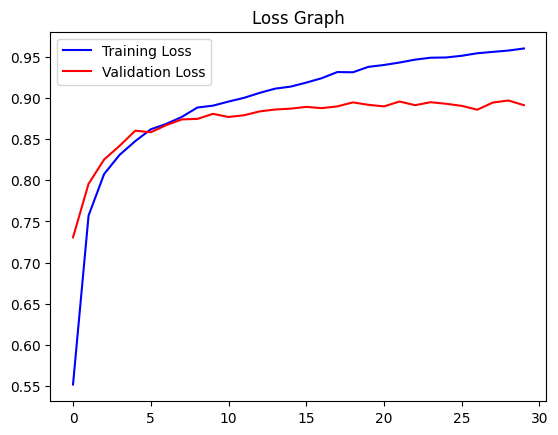

<Figure size 640x480 with 0 Axes>

In [78]:
# for age


loss = history.history['age_out_loss']
val_loss = history.history['val_age_out_loss']

epochs = range(len(loss))
plt.plot(epochs, acc,'b', label = 'Training Loss')
plt.plot(epochs,val_acc,'r', label ='Validation Loss')
plt.title('Loss Graph')
plt.legend()
plt.figure()
plt.show()

## Prediction with test data

Original Gender: Male Original Age: 1
1/1 [==============================] - 0s 36ms/step
Predicted Gender Male Predicted Age 2


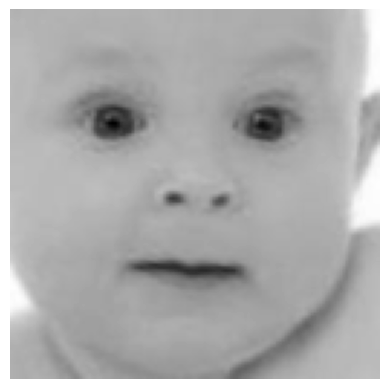

In [80]:
image_index = 100
print('Original Gender:', gender_dict[y_gender[image_index]], 'Original Age:', y_age[image_index])
##n predict from model
pred = model.predict(X[image_index].reshape(1, 128,128,1))
pred_gender = gender_dict[round(pred[0][0][0])]
pred_age = round(pred[1][0][0])
print('Predicted Gender',pred_gender, 'Predicted Age',  pred_age)
plt.axis('off')
plt.imshow(X[image_index].reshape(128,128), cmap = 'gray');

Original Gender: Male Original Age: 65
1/1 [==============================] - 0s 262ms/step
Predicted Gender Male Predicted Age 55


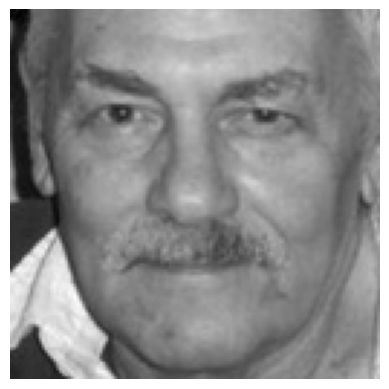

In [82]:
image_index = 1110
print('Original Gender:', gender_dict[y_gender[image_index]], 'Original Age:', y_age[image_index])
##n predict from model
pred = model.predict(X[image_index].reshape(1, 128,128,1))
pred_gender = gender_dict[round(pred[0][0][0])]
pred_age = round(pred[1][0][0])
print('Predicted Gender',pred_gender, 'Predicted Age',  pred_age)
plt.axis('off')
plt.imshow(X[image_index].reshape(128,128), cmap = 'gray');

Original Gender: Female Original Age: 61
1/1 [==============================] - 0s 90ms/step
Predicted Gender Female Predicted Age 61


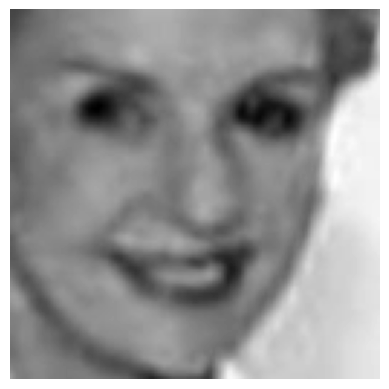

In [83]:
image_index = 110
print('Original Gender:', gender_dict[y_gender[image_index]], 'Original Age:', y_age[image_index])
##n predict from model
pred = model.predict(X[image_index].reshape(1, 128,128,1))
pred_gender = gender_dict[round(pred[0][0][0])]
pred_age = round(pred[1][0][0])
print('Predicted Gender',pred_gender, 'Predicted Age',  pred_age)
plt.axis('off')
plt.imshow(X[image_index].reshape(128,128), cmap = 'gray');

Original Gender: Male Original Age: 30
1/1 [==============================] - 0s 182ms/step
Predicted Gender Male Predicted Age 31


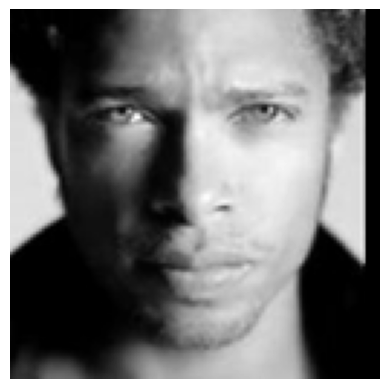

In [84]:
image_index = 1230
print('Original Gender:', gender_dict[y_gender[image_index]], 'Original Age:', y_age[image_index])
##n predict from model
pred = model.predict(X[image_index].reshape(1, 128,128,1))
pred_gender = gender_dict[round(pred[0][0][0])]
pred_age = round(pred[1][0][0])
print('Predicted Gender',pred_gender, 'Predicted Age',  pred_age)
plt.axis('off')
plt.imshow(X[image_index].reshape(128,128), cmap = 'gray');